# Toronto Fire Incident Analysis
Analysis of Toronto Fire Incident data with
Data from the Toronto Open Data Portal https://open.toronto.ca/dataset/fire-incidents/

## Questions to Answer  
1. Is there a large variability in response time by the different stations?  
2. Is the geo-spatial distribution of fire stations appropriate to all the locations? 
3. Is there a correlation between fire station proximity and response time?


## Data Extraction

In [182]:
import numpy as np
import sklearn as sk
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno
import geopandas as gpd
from shapely.geometry import Point

sns.set_palette("colorblind")

In [183]:
#Download data directly from the Toronto Open Data Portal
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/fa5c7de5-10f8-41cf-883a-9b30a67c7b56?format=csv'
df = pd.read_csv(url)
len(df)

12687

In [184]:
df.dtypes

_id                                                                int64
Area_of_Origin                                                    object
Building_Status                                                   object
Business_Impact                                                   object
Civilian_Casualties                                                int64
Count_of_Persons_Rescued                                           int64
Estimated_Dollar_Loss                                            float64
Estimated_Number_Of_Persons_Displaced                            float64
Exposures                                                        float64
Ext_agent_app_or_defer_time                                       object
Extent_Of_Fire                                                    object
Final_Incident_Type                                               object
Fire_Alarm_System_Impact_on_Evacuation                            object
Fire_Alarm_System_Operation                        

In [185]:
df.drop(columns=['Incident_Number','_id'], inplace=True)
df.head()

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,81 - Engine Area,NaN,NaN,0,0,1000.0,NaN,NaN,2015-08-29T11:52:31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,2015-08-29T11:52:04,2015-08-29T11:52:19,0
1,22 - Sleeping Area or Bedroom (inc. patients r...,01 - Normal (no change),8 - Not applicable (not a business),0,0,20.0,0.0,NaN,2017-07-02T21:39:00,1 - Confined to object of origin,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,7 - Not applicable: Occupant(s) first alerted ...,2 - Confined to part of room/area of origin,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,1 - Fire extinguished prior to arrival,2017-07-02T21:33:06,2017-07-02T21:35:59,0
2,81 - Engine Area,NaN,NaN,0,0,5000.0,NaN,NaN,2015-02-13T18:46:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4 - Flames showing from small area (one storey...,2015-02-13T18:44:29,2015-02-13T18:45:35,0
3,99 - Undetermined (formerly 98),NaN,NaN,0,0,7500.0,NaN,NaN,2015-02-14T20:16:25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2015-02-14T20:10:16,2015-02-14T20:13:03,0
4,81 - Engine Area,NaN,NaN,0,0,10000.0,NaN,NaN,2014-05-25T23:50:52,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2014-05-25T23:44:10,2014-05-25T23:49:51,0


In [186]:
#Properly designate datetime cols datatypes
datetime_cols = ['TFS_Alarm_Time',
             'TFS_Arrival_Time',
             'Last_TFS_Unit_Clear_Time',
             'Fire_Under_Control_Time',
             'Ext_agent_app_or_defer_time']

for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)

#set variables for Month & Year
df['year'] = pd.DatetimeIndex(df.TFS_Alarm_Time).year
df['month']= pd.DatetimeIndex(df.TFS_Alarm_Time).month

/home/mparravani/anaconda3/envs/geoanalysis/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mparravani/anaconda3/envs/geoanalysis/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


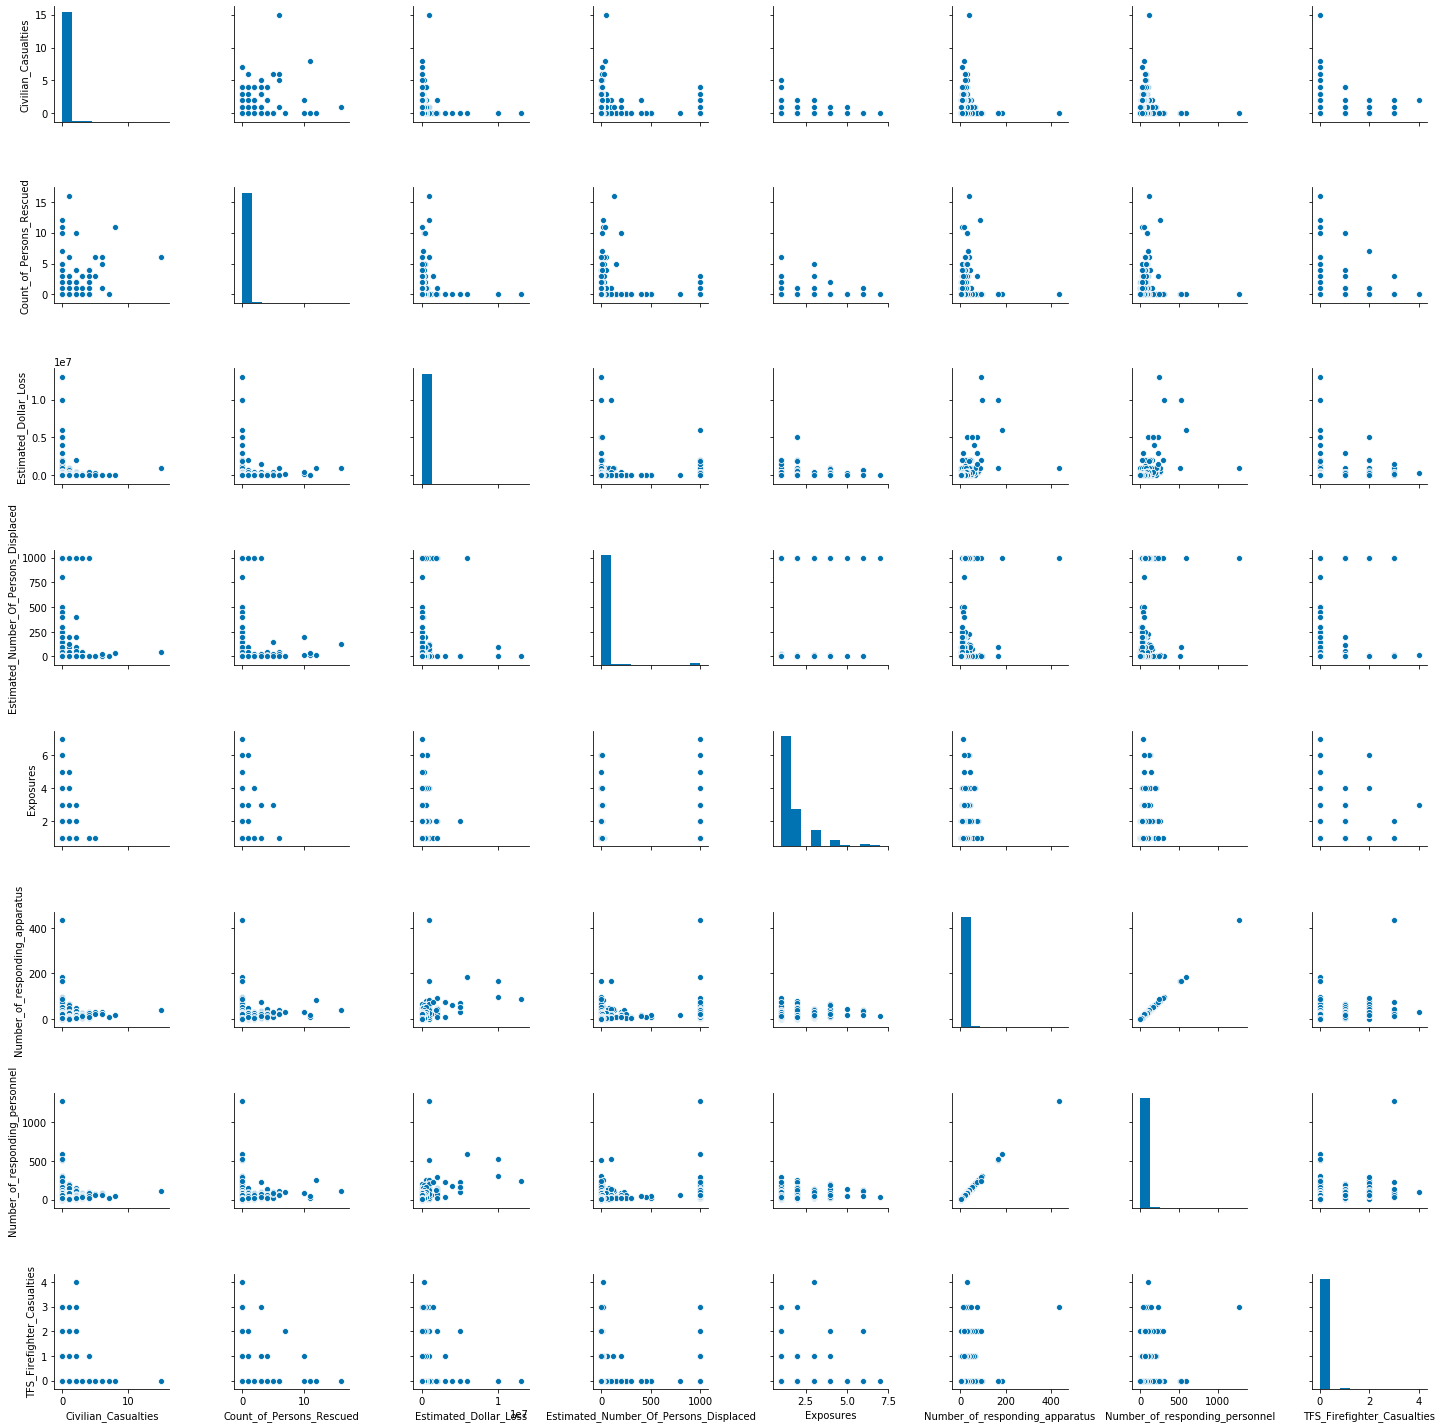

In [187]:
#Make pairplot using seaborn to establish any trends / correlations

#pull number cols, ignoring certian cols
ignorecols = ['Latitude','Longitude', 'Incident_Station_Area','Incident_Ward','year','month']
numcols = df.drop(columns=ignorecols).select_dtypes(include=['int64','float64']).columns

sns.pairplot(df[numcols])
plt.show()

Looks like most of the time, no one is requiring rescuing and there are no casualties    
there's also a strong correlation between the number of responding personel and apparatus (as one would think)   


In [188]:
#Check for missing values - establish missing % for each col
df.isna().sum() / len(df)*100

Area_of_Origin                                                    0.000000
Building_Status                                                  27.445417
Business_Impact                                                  27.461181
Civilian_Casualties                                               0.000000
Count_of_Persons_Rescued                                          0.000000
Estimated_Dollar_Loss                                             0.007882
Estimated_Number_Of_Persons_Displaced                            27.453299
Exposures                                                        97.800899
Ext_agent_app_or_defer_time                                       0.000000
Extent_Of_Fire                                                   27.461181
Final_Incident_Type                                               0.000000
Fire_Alarm_System_Impact_on_Evacuation                           27.461181
Fire_Alarm_System_Operation                                      27.461181
Fire_Alarm_System_Presenc

From the above, it seems as many columns are missing the same amount of data. Lets check if this data is missing in the same rows

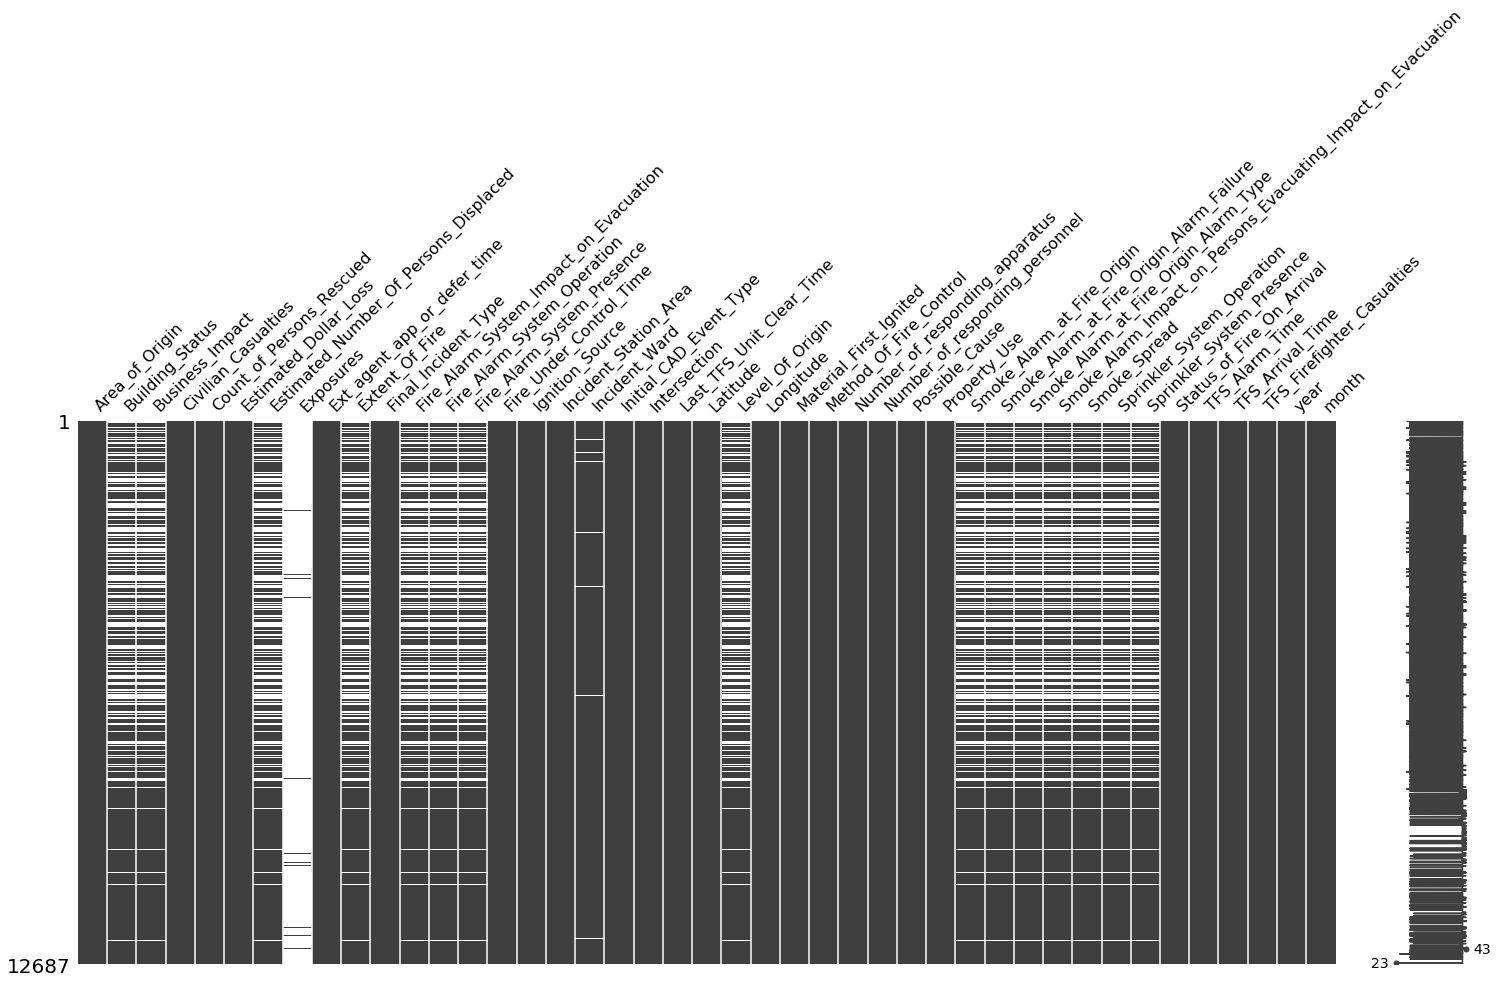

In [189]:
#check if there is correlation in missing data
msno.matrix(df)

From the above, it looks as though there is correlation in the missing data - it must be that certian buildings were not documented.
Assuming that "Exposures" is 0 unless otherwise stated.

In [190]:
df.Exposures.value_counts()

1.0    177
2.0     60
3.0     26
4.0     10
6.0      3
5.0      2
7.0      1
Name: Exposures, dtype: int64

In [191]:
df.Exposures.fillna(0, inplace = True)
df.Exposures.value_counts()

0.0    12408
1.0      177
2.0       60
3.0       26
4.0       10
6.0        3
5.0        2
7.0        1
Name: Exposures, dtype: int64

Fill Empty Values in Incident Ward

In [192]:
#Fill empty wards with most common ward for the station area

#find most common ward for each station area
ward_fill = df.groupby(by = 'Incident_Station_Area')['Incident_Ward'].agg(lambda x:x.value_counts().index[0]).to_dict() 

#fillna using a map from the station area col
df.Incident_Ward.fillna(df.Incident_Station_Area.map(ward_fill), inplace=True)

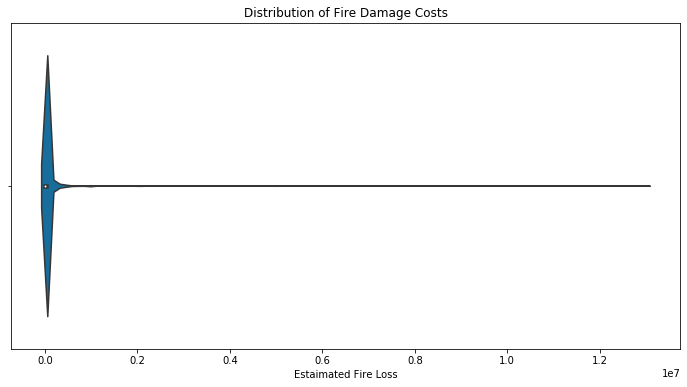

In [193]:
#Plot distribution of fires by cost
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.violinplot(df.dropna().Estimated_Dollar_Loss)
plt.title('Distribution of Fire Damage Costs')
plt.xlabel('Estaimated Fire Loss')

plt.show()

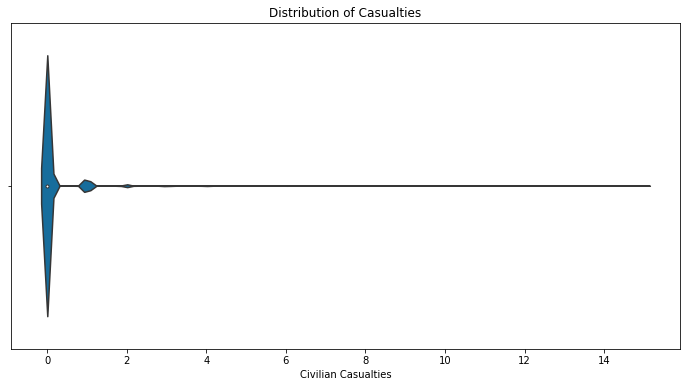

In [194]:
#Plot distribution of fires by cost
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.violinplot(df.dropna().Civilian_Casualties)
plt.title('Distribution of Casualties')
plt.xlabel('Civilian Casualties')

plt.show()

This is great news - that most fires have no casualties, while very few only have 1 or 2.

## Question 1 - Activity and Response Time by Station

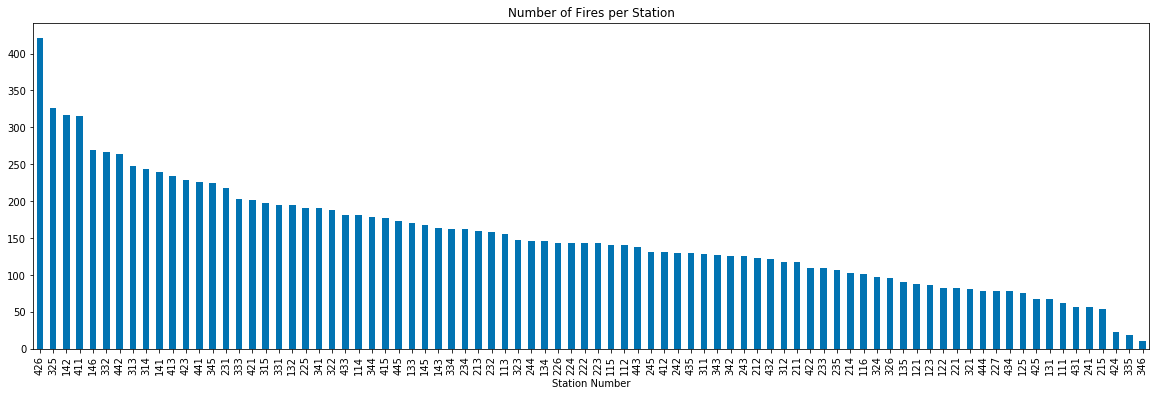

In [195]:
#Distribution of Fire count by station
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
df['Incident_Station_Area'].value_counts().plot(kind = 'bar')
plt.title('Number of Fires per Station')
plt.xlabel('Station Number')

plt.show()

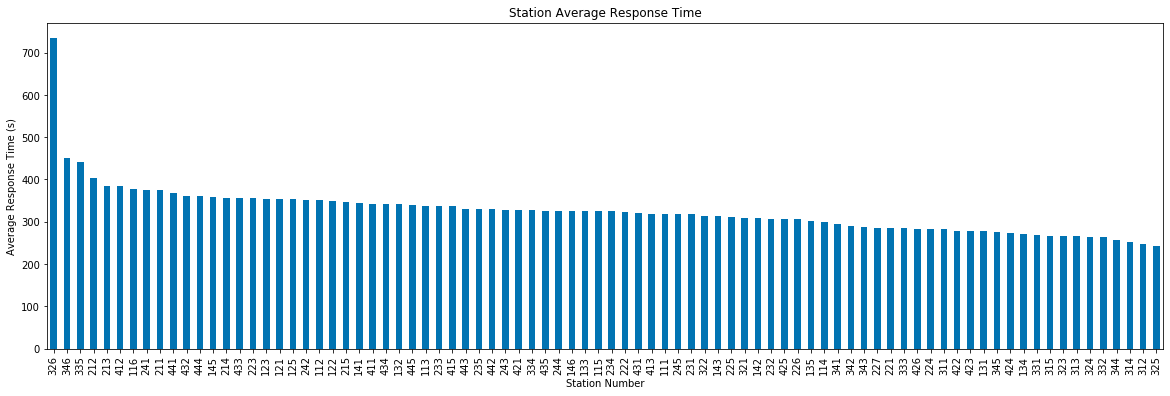

In [196]:
#Plot out Response Times by station

#calculate response time for each fire
df['TFS_Response_Time'] = df.apply(lambda x: (x.TFS_Arrival_Time-x.TFS_Alarm_Time).seconds, axis = 1)

fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
df.groupby('Incident_Station_Area')['TFS_Response_Time'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.title('Station Average Response Time')
plt.xlabel('Station Number')
plt.ylabel('Average Response Time (s)')

plt.show()


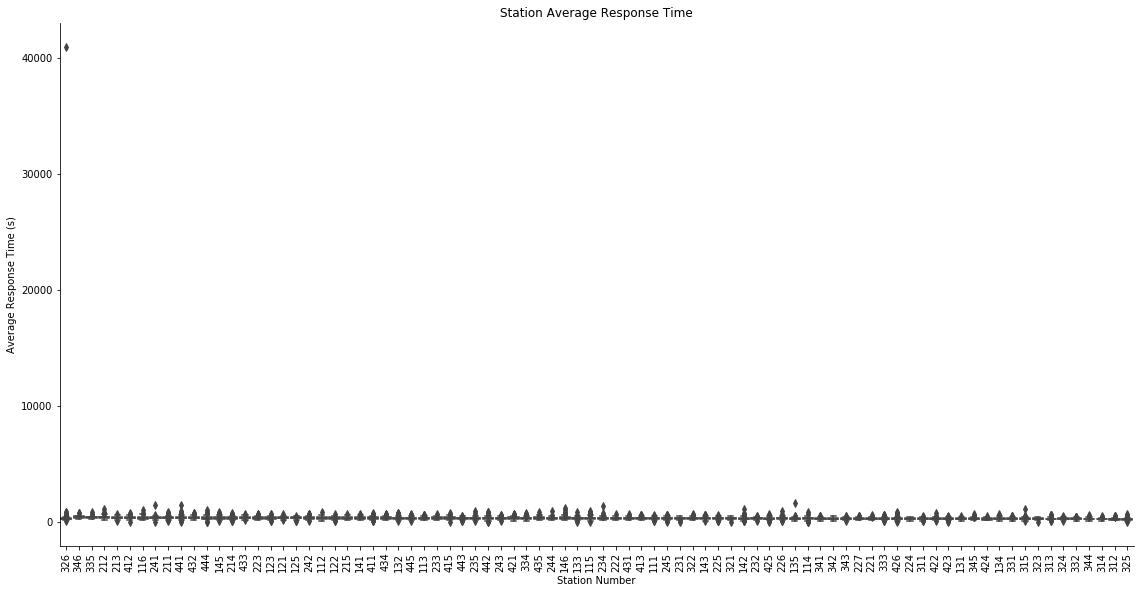

In [197]:
#recreating the above with boxplots to see if there are outliers

tmp = df.groupby(by = 'Incident_Station_Area', as_index = False)['TFS_Response_Time'].mean()
tmp.sort_values(by='TFS_Response_Time', ascending = False, inplace = True)

sns.catplot(data = df, x = 'Incident_Station_Area', y = 'TFS_Response_Time', kind = 'box', height = 8, aspect = 2, order = tmp.Incident_Station_Area)
plt.title('Station Average Response Time')
plt.xlabel('Station Number')
plt.ylabel('Average Response Time (s)')
plt.xticks(rotation=90)

plt.show()


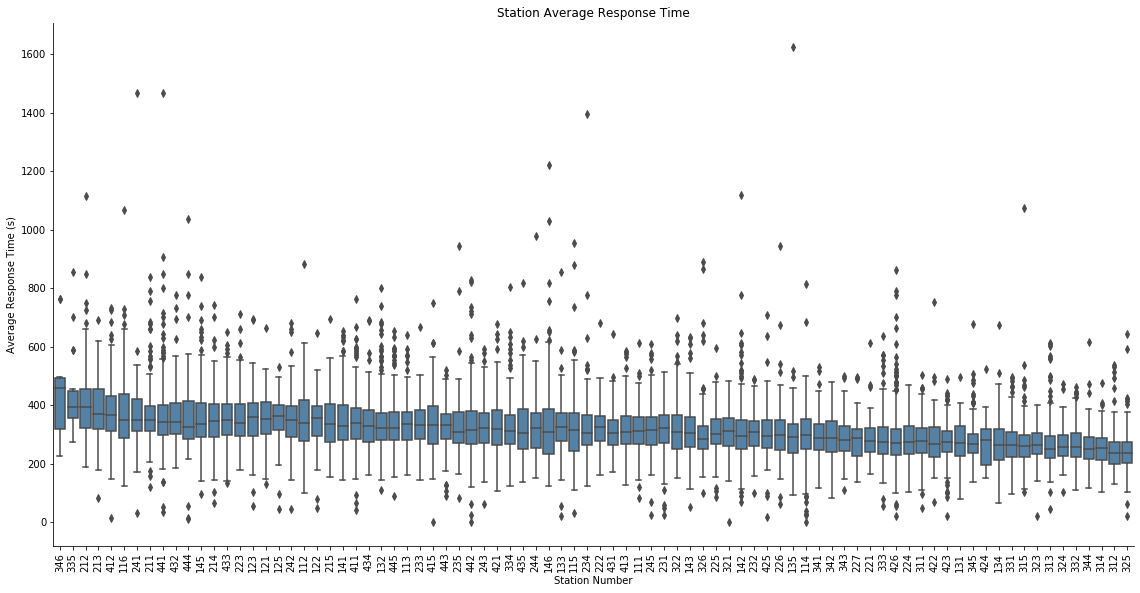

In [198]:
#There's one obvious outlier, lets recompile the above excluding that outlier
#proceeding with excluding the outlier where appropriate

tmp = df[df.TFS_Response_Time<40000].groupby(by = 'Incident_Station_Area', as_index = False)['TFS_Response_Time'].mean()
tmp.sort_values(by='TFS_Response_Time', ascending = False, inplace = True)

sns.catplot(data = df[df.TFS_Response_Time<40000], 
            x = 'Incident_Station_Area', 
            y = 'TFS_Response_Time', 
            kind = 'box', 
            height = 8, 
            aspect = 2, 
            color = 'steelblue',
            order = tmp.Incident_Station_Area)
plt.title('Station Average Response Time')
plt.xlabel('Station Number')
plt.ylabel('Average Response Time (s)')
plt.xticks(rotation=90)

plt.show()

#without the outlier, station 326 is now one of the top performers wrt average response time


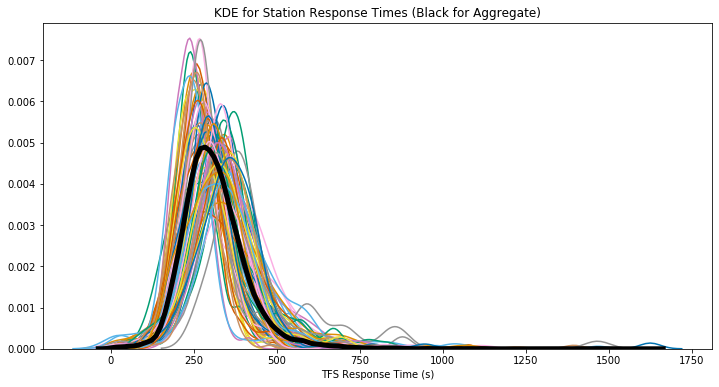

In [199]:
#looking at variability of distributions
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

for stn in list(set(fire_gdf.Incident_Station_Area)):
    sns.distplot(fire_gdf.loc[(fire_gdf.TFS_Response_Time<40000) &(fire_gdf.Incident_Station_Area==stn)]['TFS_Response_Time'], hist = False)

sns.distplot(fire_gdf.loc[(fire_gdf.TFS_Response_Time<40000)]['TFS_Response_Time'], hist = False, color = 'black',kde_kws={"linewidth": 5})

plt.title('KDE for Station Response Times (Black for Aggregate)')
plt.xlabel('TFS Response Time (s)')

plt.show()

## Question 2 - Geospatial Distribution of Fire vs Stations

In [200]:
#load in neighborhoods shapefile
map_df = gpd.read_file('neighbourhoods_planning_areas_wgs84/NEIGHBORHOODS_WGS84.shp')

#load in firestations shapefile
firestation_gdf = gpd.read_file('fire-station-locations-wgs84/FIRE_FACILITY_WGS84.shp')

def geo_toronto_optimize(gdf, column):
    '''
        Converts coordinate columns of a geopandas dataframe to epsg 2019, and rotates for optimal viewing of Toronto 
        
        INPUT:
        gdf - a geopandas dataframe containing a column of coordinates 
        coord_col - column requiring to be converted

        OUTPUT:
        gdf - a geopandas dataframe with a converted column optimal for plotting Toronto
    '''

    gdf[column] = gdf[column].to_crs(epsg=2019)
    gdf[column] = gdf[column].rotate(angle = -17, origin=(315000,4840000), use_radians=False)
    
    return gdf


#prepare fire data coordinates
df['coordinates']=list(zip(df.Longitude, df.Latitude))
df['coordinates'] = df['coordinates'].apply(Point)

crs = {'init': 'epsg:4326'} #initialize crs
fire_gdf = gpd.GeoDataFrame(df, crs=crs,geometry='coordinates')

#update crs and rotate all datasets for better plotting
map_df = geo_toronto_optimize(map_df, 'geometry')
firestation_gdf = geo_toronto_optimize(firestation_gdf, 'geometry')
fire_gdf = geo_toronto_optimize(fire_gdf, 'coordinates')

#get fire data lon and lat for crs2019
fire_gdf['lon_crs2019'] = fire_gdf.coordinates.x
fire_gdf['lat_crs2019'] = fire_gdf.coordinates.y


firestation_gdf.NAME=firestation_gdf.NAME.apply(lambda x: x.split('FIRE STATION ')[1])


/home/mparravani/anaconda3/envs/geoanalysis/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


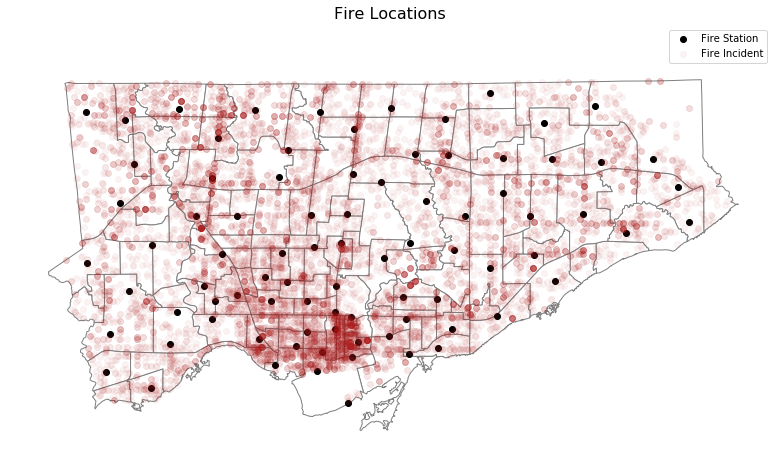

In [201]:
#plot all fires
xlim = (292500,340000)
ylim = (4828000,4855000)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
map_df.plot(ax=ax, color='white',edgecolor = 'grey')
firestation_gdf.plot(ax=ax, color='black', label='Fire Station')
sns.scatterplot("lon_crs2019", "lat_crs2019", data=fire_gdf,color = 'firebrick', edgecolor = None ,alpha = 0.05, label = 'Fire Incident')

plt.xlim(xlim)
plt.ylim(ylim)
ax.axis('off')
plt.title('Fire Locations', fontsize = 16)
plt.legend()

plt.show()

Seems as the highest concentration of fires are reported downtown, along with a high densite of fire stations

In [202]:
#Calculate distance from fires to their stations
tmp = firestation_gdf[['NAME','geometry']]
tmp.columns = ['NAME','fs_geometry']

fire_gdf.Incident_Station_Area = fire_gdf.Incident_Station_Area.astype('str')
fire_gdf = fire_gdf.merge(tmp, left_on = 'Incident_Station_Area', right_on = 'NAME' )

# fire_gdf['distance_from_stn'] = fire_gdf.apply(lambda x: x['coordinates'].distance(x['fs_geometry']), axis=1)

fire_gdf['distance_to_fs'] = fire_gdf.apply(lambda x: x['coordinates'].distance(x['fs_geometry']), axis=1)

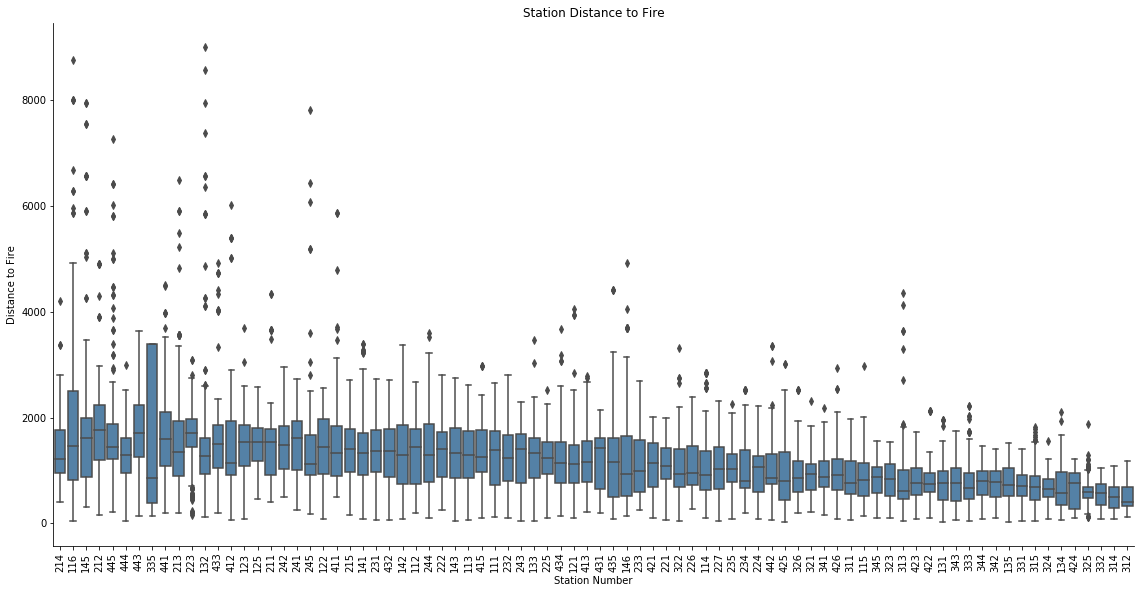

In [228]:
#Plot distance to fire by fire station

tmp = fire_gdf.groupby(by = 'Incident_Station_Area', as_index = False)['distance_to_fs'].mean()
tmp.sort_values(by='distance_to_fs', ascending = False, inplace = True)

sns.catplot(data = fire_gdf.loc[fire_gdf.distance_to_fs<35000], #have to filter 1 distance off due to overflow issues, and 1 outlier
            x = 'Incident_Station_Area', 
            y = 'distance_to_fs', 
            kind = 'box', 
            height = 8, 
            aspect = 2, 
            color = 'steelblue',
            order = tmp.Incident_Station_Area)

plt.title('Station Distance to Fire')
plt.xlabel('Station Number')
plt.ylabel('Distance to Fire')
plt.xticks(rotation=90)

plt.show()

#without the outlier, station 326 is now one of the top performers wrt average response time


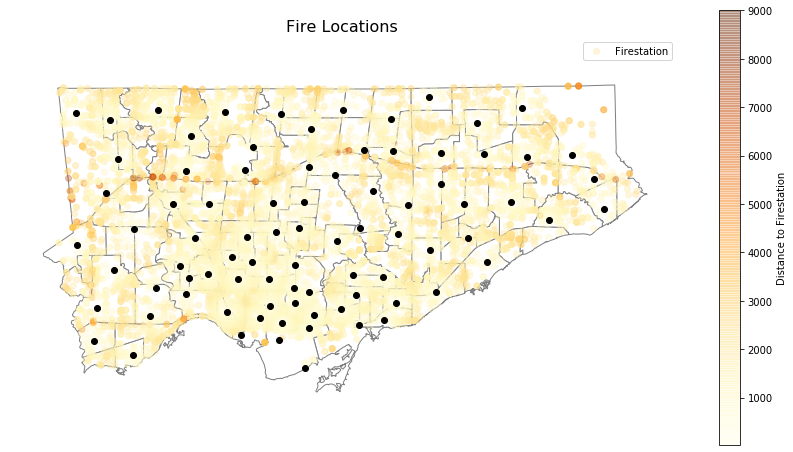

In [247]:
#plot fires by response time
xlim = (292500,340000)
ylim = (4828000,4855000)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

map_df.plot(ax=ax, color='white',edgecolor = 'grey')
plt.scatter(x="lon_crs2019", y="lat_crs2019",
            data=fire_gdf.loc[fire_gdf.distance_to_fs<35000],
            c = 'distance_to_fs',
            edgecolor = None ,
            alpha = 0.3, 
            cmap = "YlOrBr")
firestation_gdf.plot(ax=ax, color='black', label='Fire Station')



plt.xlim(xlim)
plt.ylim(ylim)
ax.axis('off')
plt.title('Fire Locations', fontsize = 16)
plt.legend(['Firestation'])
plt.colorbar(label='Distance to Firestation')

plt.show()

From the above, there are a couple areas (upper left) where a firestation seems to be close by, but there is still a long travel distance. Must be a response from a further station. Attention could be paid to there